# Objective:

Identify cat and dog from picture

## Import packages

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/archive.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import os

# Suppress Warning and only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = INFO, 2 = WARNING, 3 = ERROR

# List Inputs
print(os.listdir('/content/dogs_vs_cats'))
# print(os.listdir('/kaggle/input/predict-cat-dog/'))

['test', 'train']


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import numpy as np

import cv2

## Use Generator to Load the Data

Generators are used to automatically load Data in memory in batches.

In [5]:
# Generators
train_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dogs_vs_cats/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256)
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dogs_vs_cats/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256)
)

print(f'Training Classes [0, 1]: {train_dataset.class_names}')
print(f'Testing Classes  [0, 1]: {test_dataset.class_names}')

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training Classes [0, 1]: ['cats', 'dogs']
Testing Classes  [0, 1]: ['cats', 'dogs']


## Normalize the data between 0 and 1

In [6]:
# Normalize Data between 0 and 1
def process(image, label):
    image = tf.cast(image/255, tf.float32)
    return image, label

train_dataset = train_dataset.map(process)
test_dataset = test_dataset.map(process)

## Create a CNN Model

In [7]:
# Create CNN Model
model = Sequential(name="cats_vs_dogs_classifier")

# Input layer
model.add(Input(shape=(256, 256, 3)))

# First Convolution & Pooling Layer
model.add(Conv2D(
    filters=32, kernel_size=(3,3), padding="valid", activation="relu"
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Second Convolution & Pooling Layer
model.add(Conv2D(
    filters=64, kernel_size=(3,3), padding="valid", activation="relu"
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Third Convolution & Pooling Layer
model.add(Conv2D(
    filters=128, kernel_size=(3,3), padding="valid", activation="relu"
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Flatten Layer
model.add(Flatten())

# Fully connected ANN Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "cats_vs_dogs_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

## Add Early Stopping Criteria and Build the Model

In [9]:
earlystopping = EarlyStopping(
    monitor="val_loss", patience=2,
    restore_best_weights=True
)

In [10]:
model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [12]:
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = test_dataset,
    callbacks=[earlystopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.6387 - loss: 0.6306 - val_accuracy: 0.6774 - val_loss: 0.5916
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.6863 - loss: 0.5584 - val_accuracy: 0.7512 - val_loss: 0.5002
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7187 - loss: 0.5017 - val_accuracy: 0.7384 - val_loss: 0.5974
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.7523 - loss: 0.4623 - val_accuracy: 0.7644 - val_loss: 0.5377


## Plot Accuracy and Loss

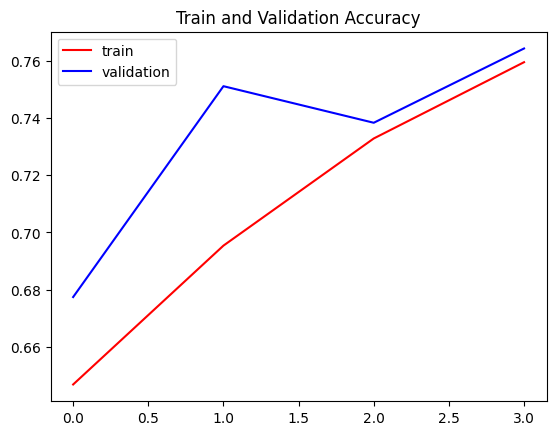

In [13]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

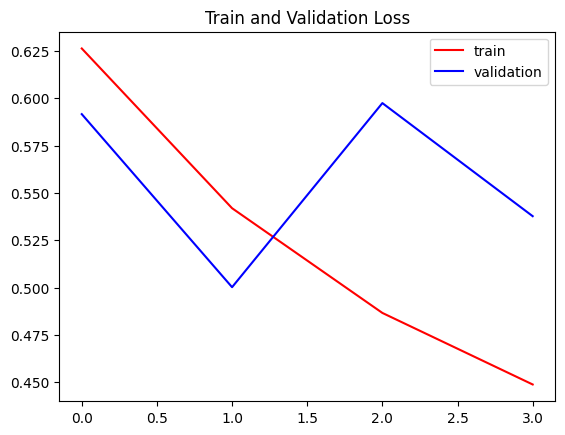

In [14]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Prediction

## Load new images of Cat and Dog for prediction

In [15]:
test_img_cat = cv2.imread("/content/test/cats/cat.10007.jpg") # Class 0
test_img_dog = cv2.imread("/content/test/dogs/dog.10010.jpg") # Class 1

In [16]:
# Reduce image size to 256 x 256 pixels
test_img_dog = cv2.resize(test_img_dog, (256, 256))
test_img_cat = cv2.resize(test_img_cat, (256, 256))

In [17]:
input_for_test = np.array([
    test_img_dog.reshape((1, 256, 256, 3)),
    test_img_cat.reshape((1, 256, 256, 3))
], dtype=np.float32) / 256.0

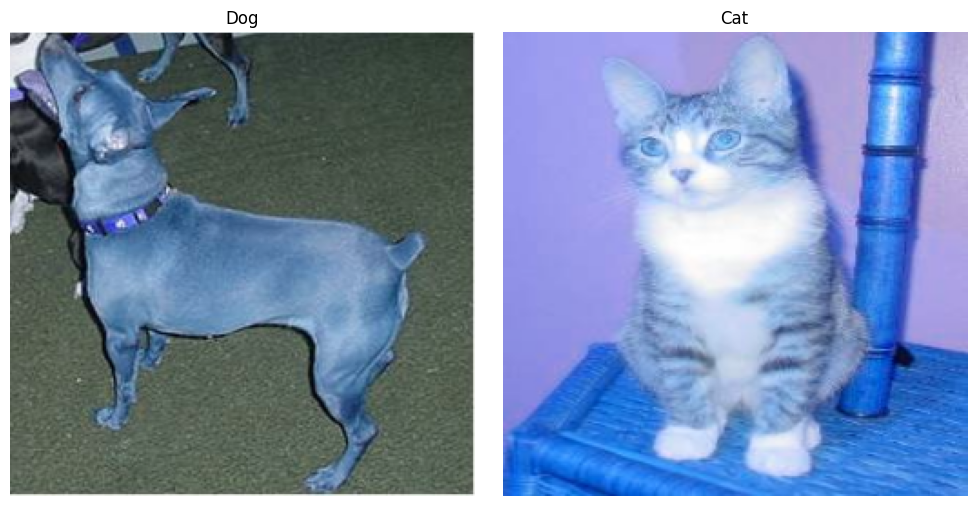

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_img_dog)
plt.title("Dog")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(test_img_cat)
plt.title("Cat")
plt.axis("off")

plt.tight_layout()
plt.show()

## Make Prediction

In [19]:
predict_labels = ['Cat', 'Dog'] # Class 0 is Cat and Class 1 is Dog
preds = []
for i in range(len(input_for_test)):
    preds.append(model.predict(input_for_test[i]))

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


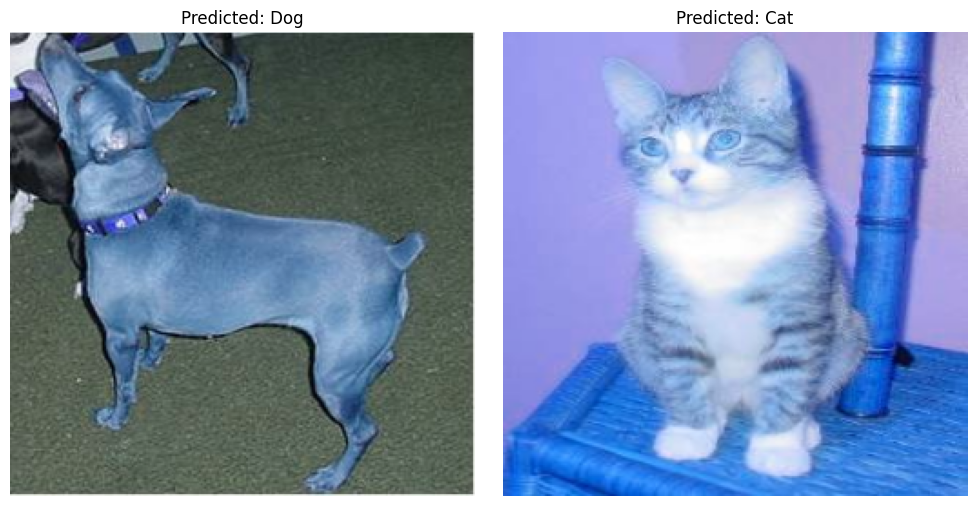

In [20]:
# Plot predictions alongside images
plt.figure(figsize=(10, 5))

for i, pred in enumerate(preds):
    plt.subplot(1, len(preds), i + 1)

    plt.imshow((input_for_test[i][0] * 256).astype(np.uint8))

    # Decode label
    label_idx = int(np.round(pred[0][0]))  # or np.argmax(pred[0]) for softmax
    plt.title(f"Predicted: {predict_labels[label_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
model.save('my_cat_dog_classifier.h5')